## 2. Create 2D Occupancy grid

In [ ]:
import open3d as o3d
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import cv2
from skimage.draw import line
import heapq
import matplotlib.pyplot as plt


In [2]:
# Step 1: Load the PLY file
point_cloud = o3d.io.read_point_cloud("cleaned_maze.ply") #week 1 maze


In [3]:
""" Visualise filtered point cloud"""
o3d.visualization.draw_geometries([point_cloud]) 

2024-12-11 14:53:06.522 python[92933:3550940] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-11 14:53:06.522 python[92933:3550940] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [4]:
"""flatten z coordinates"""
point_cloud_np = np.asarray(point_cloud.points) 
# point_cloud_np = point_cloud_np[:, [0,2]] #removes z dimension
point_cloud_np[:, 1] = 0 # sets z dimension to 0

print(point_cloud_np[0, :])

[-5.19326019  0.         -9.71401978]


In [5]:
"""Show flattened maze"""
flattened_pc = o3d.geometry.PointCloud()
flattened_pc.points = o3d.utility.Vector3dVector(point_cloud_np)

o3d.visualization.draw_geometries([flattened_pc]) 

### Create Grid

In [6]:
import numpy as np

# Indices: y at 0, z at 1, x at 2.
# only use x and y

y_coords = point_cloud_np[:, 0]
x_coords = point_cloud_np[:, 2]

resolution = 0.2 # grid size

# min and max points
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

# Compute the size of the grid
x_size = int(np.ceil((x_max - x_min) / resolution))
y_size = int(np.ceil((y_max - y_min) / resolution))


#count number of points per grid cell
count_grid = np.zeros((y_size, x_size), dtype=np.int32)
for i in range(len(x_coords)):
    # Translate coordinates to grid indices
    x_idx = int((x_coords[i] - x_min) / resolution)
    y_idx = int((y_coords[i] - y_min) / resolution)
    count_grid[y_idx, x_idx] += 1


#if more points in cell than threshold, mark as occupied
threshold = 5
grid = np.zeros_like(count_grid, dtype=np.uint8)
grid[count_grid >= threshold] = 1 #initialise grid, 0 = free, 1 = occupied


print("Grid shape:", grid.shape)


Grid shape: (85, 65)


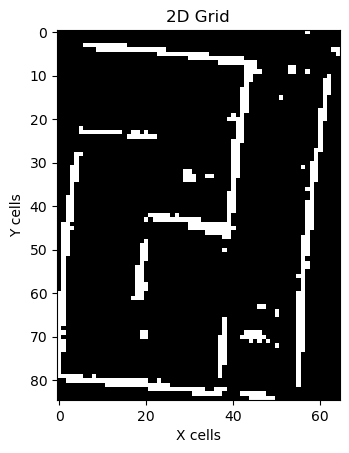

In [7]:
import matplotlib.pyplot as plt

grid = np.flipud(grid) #flip the grid to match the point cloud
plt.imshow(grid, cmap='gray', origin='upper')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Grid')
plt.show()

#TODO need to rotate to the left right after loading the point cloud (in filter_keypoints)


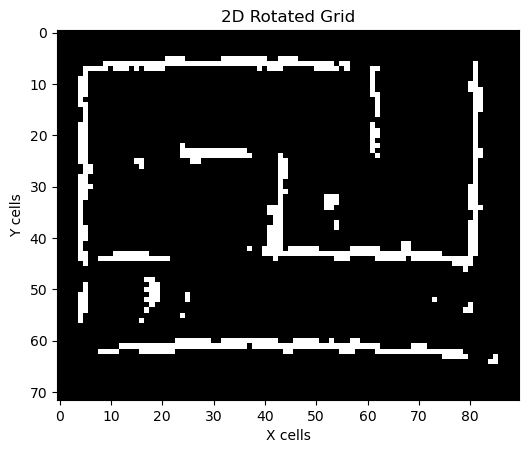

In [8]:
# Perform Hough Transform
hspace, angles, distances = hough_line(grid)
# Find peaks in the Hough transform
_, peak_angles, _ = hough_line_peaks(hspace, angles, distances)

# Normalize angles to 0-180 degrees
normalized_angles = np.rad2deg(peak_angles) % 180

# Create histogram of angles
hist, bins = np.histogram(normalized_angles, bins=180, range=(0, 180))

# Find the two largest peaks in the histogram
peaks = np.argsort(hist)[-1]  # Indices of two largest bins
theta_h = bins[peaks]

rotation_angle = (theta_h - 90)
(h, w) = grid.shape[:2]
center = (w // 2, h // 2)

# Compute the bounding box of the rotated image
cos_theta = np.abs(np.cos(np.deg2rad(rotation_angle)))
sin_theta = np.abs(np.sin(np.deg2rad(rotation_angle)))
new_w = int((h * sin_theta) + (w * cos_theta))
new_h = int((h * cos_theta) + (w * sin_theta))

# Adjust the rotation matrix to account for the translation
M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
M[0, 2] += (new_w - w) / 2
M[1, 2] += (new_h - h) / 2

# Perform the rotation
rotated = cv2.warpAffine(grid, M, (new_w, new_h))

plt.imshow(rotated, cmap='gray', origin='upper')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

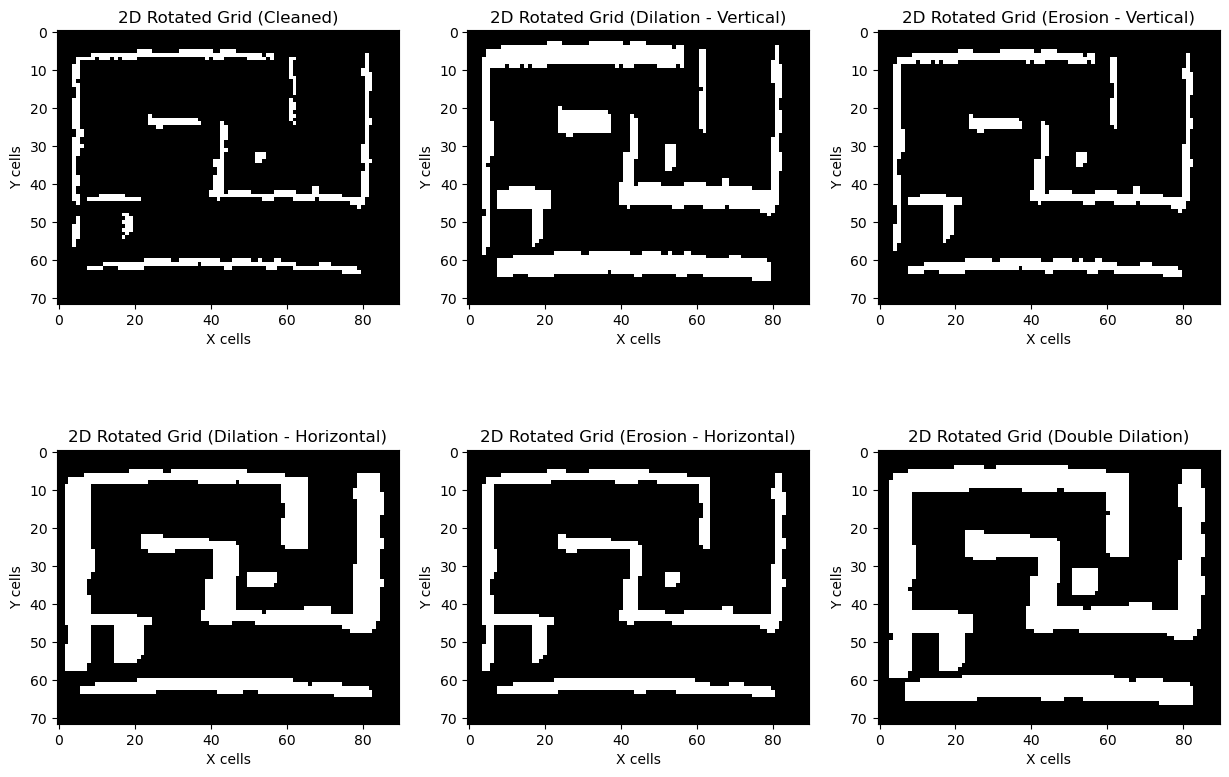

In [9]:
# Remove isolated pixels
connectivity = 8
output = cv2.connectedComponentsWithStats(rotated, connectivity, cv2.CV_32S)

num_stats = output[0] # total number of connected components
labels = output[1] # labeled version of the image where each component is assigned a unique integer label
stats = output[2] # statistics about each component (including its area, bounding box, and other properties).

new_image = rotated.copy()
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for label in range(num_stats):  # foes through each connected component
    if stats[label,cv2.CC_STAT_AREA] == 1 or stats[label,cv2.CC_STAT_AREA] == 2 or stats[label,cv2.CC_STAT_AREA] == 3  :
        new_image[labels == label] = 0
ax[0].imshow(new_image, cmap='gray', origin='upper')
ax[0].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Cleaned)')

# Dilation
kernel_dilation_v = np.ones((5,1), np.uint8)
dilated_image_v = cv2.dilate(new_image, kernel_dilation_v, iterations=1)
ax[1].imshow(dilated_image_v, cmap='gray', origin='upper')
ax[1].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Dilation - Vertical)')

# Erosion
kernel_erosion = np.ones((4,1), np.uint8)
eroded_image2 = cv2.erode(dilated_image_v, kernel_erosion, iterations=1)
ax[2].imshow(eroded_image2, cmap='gray', origin='upper')
ax[2].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Erosion - Vertical)')

# Dilation
kernel_dilation_h = np.ones((1, 6), np.uint8)
dilated_image_h = cv2.dilate(eroded_image2, kernel_dilation_h, iterations=1)
ax[3].imshow(dilated_image_h, cmap='gray', origin='upper')
ax[3].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Dilation - Horizontal)')

# Erosion
kernel_erosion = np.ones((1,5), np.uint8)
eroded_image = cv2.erode(dilated_image_h, kernel_erosion, iterations=1)
ax[4].imshow(eroded_image, cmap='gray', origin='upper')
ax[4].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Erosion - Horizontal)')

# Double Dilation
kernel_dilation = np.ones((4, 4), np.uint8)
dilated_image = cv2.dilate(eroded_image, kernel_dilation, iterations=1)
ax[5].imshow(dilated_image, cmap='gray', origin='upper')
ax[5].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Double Dilation)')
plt.show()

Shortest path: [(np.int64(50), np.int64(70)), (np.int64(51), np.int64(70)), (np.int64(52), np.int64(70)), (np.int64(53), np.int64(70)), (np.int64(53), np.int64(69)), (np.int64(53), np.int64(68)), (np.int64(53), np.int64(67)), (np.int64(53), np.int64(66)), (np.int64(53), np.int64(65)), (np.int64(53), np.int64(64)), (np.int64(53), np.int64(63)), (np.int64(53), np.int64(62)), (np.int64(53), np.int64(61)), (np.int64(53), np.int64(60)), (np.int64(53), np.int64(59)), (np.int64(53), np.int64(58)), (np.int64(53), np.int64(57)), (np.int64(53), np.int64(56)), (np.int64(53), np.int64(55)), (np.int64(53), np.int64(54)), (np.int64(53), np.int64(53)), (np.int64(53), np.int64(52)), (np.int64(53), np.int64(51)), (np.int64(53), np.int64(50)), (np.int64(53), np.int64(49)), (np.int64(53), np.int64(48)), (np.int64(53), np.int64(47)), (np.int64(53), np.int64(46)), (np.int64(53), np.int64(45)), (np.int64(53), np.int64(44)), (np.int64(53), np.int64(43)), (np.int64(53), np.int64(42)), (np.int64(53), np.int64(

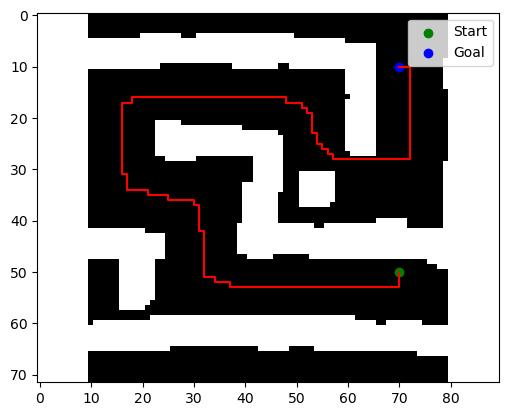

In [36]:
from scipy.ndimage import distance_transform_edt
# Assuming 'grid' is a 2D NumPy array where 0 represents free space and 1 represents obstacles

def dijkstra(grid, start, goal):
    rows, cols = grid.shape
    # Distance from start to each cell initialized to infinity
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    # Previous node in optimal path initialization
    prev = np.full((rows, cols, 2), -1, dtype=int)

    # Priority queue of (distance, (x, y))
    heap = [(0, start)]

    while heap:
        dist, current = heapq.heappop(heap)

        x, y = current
        if grid[x, y] == 1:  # Skip if it's an obstacle
            continue

        if current == goal:
            break

        # Explore neighbors (up, down, left, right)
        neighbors = [
            (x - 1, y),  # Up
            (x + 1, y),  # Down
            (x, y - 1),  # Left
            (x, y + 1),  # Right
        ]

        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols:
                if grid[nx, ny] == 0:
                    new_dist = dist + 1  # Assuming uniform cost
                    if new_dist < distances[nx, ny]:
                        distances[nx, ny] = new_dist
                        prev[nx, ny] = [x, y]
                        heapq.heappush(heap, (new_dist, (nx, ny)))

    # Reconstruct path
    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()
    return path


def create_penalty_map(grid, max_penalty=10):
    # Invert the grid: obstacles become 0, free space becomes 1
    inverted_grid = 1 - grid
    # Compute the distance transform
    distance_map = distance_transform_edt(inverted_grid)
    # Normalize the distance map to the range [0, max_penalty]
    penalty_map = max_penalty * (1 - distance_map / np.max(distance_map))
    return penalty_map

def dijkstra_with_penalty(grid, start, goal, penalty_map):
    rows, cols = grid.shape
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    prev = np.full((rows, cols, 2), -1, dtype=int)
    heap = [(0, start)]

    while heap:
        dist, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue

        if current == goal:
            break

        neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_dist = dist + 1 + penalty_map[nx, ny]
                if new_dist < distances[nx, ny]:
                    distances[nx, ny] = new_dist
                    prev[nx, ny] = [x, y]
                    heapq.heappush(heap, (new_dist, (nx, ny)))

    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()
    return path


def manhattan_distance(a, b):
    """Calculate the Manhattan distance between two points a and b."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(grid, start, goal):
    rows, cols = grid.shape
    # Initialize distances from start to each cell as infinity
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    # Initialize the previous node tracker
    prev = np.full((rows, cols, 2), -1, dtype=int)

    # Priority queue with tuples: (estimated_total_cost, cost_so_far, (x, y))
    heap = [(manhattan_distance(start, goal), 0, start)]

    while heap:
        estimated_total_cost, cost_so_far, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue  # Skip obstacles

        if current == goal:
            break  # Goal reached

        # Four adjacent movements: up, down, left, right
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy

            # Check boundaries and obstacles
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_cost = cost_so_far + 1  # Assume uniform cost
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    prev[nx, ny] = [x, y]
                    # Update the estimated total cost with heuristic
                    estimated = new_cost + manhattan_distance((nx, ny), goal)
                    heapq.heappush(heap, (estimated, new_cost, (nx, ny)))

    # Reconstruct the path from goal to start
    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path  # Empty path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()  # Reverse to get path from start to goal
    return path


def a_star_with_penalty(grid, start, goal, penalty_map):
    rows, cols = grid.shape
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    prev = np.full((rows, cols, 2), -1, dtype=int)
    heap = [(manhattan_distance(start, goal), 0, start)]

    while heap:
        estimated_total_cost, cost_so_far, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue

        if current == goal:
            break

        neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_cost = cost_so_far + 1 + penalty_map[nx, ny]
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    prev[nx, ny] = [x, y]
                    estimated = new_cost + manhattan_distance((nx, ny), goal)
                    heapq.heappush(heap, (estimated, new_cost, (nx, ny)))

    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()
    return path


# Define your grid (0 = free space, 1 = obstacle)
grid = dilated_image.copy()
penalty_map = create_penalty_map(grid)
# Pad the inside of the grid to prevent the path from going through the walls

# Define border thickness
border_thickness = 10

# Create a mask for the inside region
rows, cols = grid.shape
inside_border = np.zeros_like(grid)
inside_border[:, border_thickness:cols-border_thickness] = 1

# Apply the border values (e.g., replace inside border with a specific value)
border_value = 1  # Value for the inside border
grid[inside_border == 0] = border_value


# Define start and goal positions
# (coordinates are y, x)
start = (50, 70)
goal = (10, 70)

path = dijkstra_with_penalty(grid, start, goal, penalty_map=penalty_map)
print("Shortest path:", path)

# Visualize the grid and the path
plt.imshow(1-grid, cmap='Greys', origin='upper')

# Plot the path
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_y, path_x, color='red')  # Note: x and y are swapped due to image coordinates

plt.scatter(start[1], start[0], marker='o', color='green', label='Start')
plt.scatter(goal[1], goal[0], marker='o', color='blue', label='Goal')
plt.legend()
plt.show()